
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3 <br>
<font color=696880 size=4>
    Amirabbas Afzali 

____

# Personal Data

In [1]:
# Set your student number
student_number = '400101967'
Name = 'Ehsan'
Last_Name = 'Merrikhi'

# Rules
- Make sure that all of your cells can be run perfectly. 
- Try to minimize your use of ChatGPT (or any other AI assistant) as much as possible.
- You must create a report for this task in PDF format and explain the main results.

---

## **Introduction**

Large Language Models (LLMs) are a class of deep learning models designed for processing and generating natural language. These models are trained using large amounts of textual data and utilize architectures based on transformers. Some of the applications of these models include text generation, machine translation, text summarization, question answering, and text classification.

### *Encoder-Decoder LLMs*

One of the common architectures in large language models is the Encoder-Decoder architecture. In this architecture, the encoder processes an input sequence and maps it to a latent space. Then, the decoder uses this latent space to generate an output sequence. Models like T5 [1] (Text-to-Text Transfer Transformer) use this architecture to perform various tasks. In T5, all tasks are expressed in a "text-to-text" format, meaning both input and output are text. This model has capabilities such as translation, summarization, and text classification. One of the advantages of the Encoder-Decoder architecture is that it allows the encoder to utilize information from both before and after a word to gain a more comprehensive understanding of the text.

### *Decoder-only LLMs*

Decoder-only models, such as GPT-2, GPT-3, and LLaMA [2], unlike the Encoder-Decoder architecture, only use the decoder part. These models use an autoregressive mode, meaning they predict the next token based on previous tokens. These models are highly efficient for text generation and have found widespread applications today.

Advantages of Decoder-only Models

- Efficiency: Decoder-only models are more efficient than Encoder-Decoder models due to the absence of an independent encoder. This makes them require fewer computational and memory resources.
- Simplicity: Due to their autoregressive nature, these models can easily generate sequences in order.
- Scalability: Due to their simpler architecture, these models can be scaled to much larger sizes.


However, one of the drawbacks of these models is that they can only utilize information from tokens before the current token and cannot use tokens that come after for prediction. This limitation is significant in tasks like classification or translation, where a full understanding of the sequence is needed.



## **Objective of the Exercise**


In this exercise, the goal is to convert a generative Decoder-only language model into an encoder and evaluate its performance on a binary sentiment classification task. The main aim is to modify the Decoder-only model so that it can function as an encoder and better handle tasks requiring bidirectional understanding.

## **In this exercise, you should:**


### In this exercise, you should:

1. **Import a Decoder-only model** and load the weights of a pre-trained version of the model.
2. **Generate several outputs from the model**, and include at most 10 sample outputs in your report for different inputs.  
   You should also briefly explain the effects of key configurations in text generation, including:  
   - `Temperature`
   - `top_k`
   - `top_p`
   - `repetition_penalty`
   - `num_beams`
   - `no_repeat_ngram_size`
3. **Load the SST-2 dataset**, which is part of the GLUE benchmark for sentiment classification.  
   - Note that the model’s output depends on the number of input tokens. 
   - Apply necessary padding to the dataset after loading it to allow for parallel execution of the model.
4. **Remove the model’s final layer**, which outputs to the size of the model’s dictionary.  
   - Use the embedding vector of the first token (CLS token) for classification.
5. As observed in the previous step, sometimes the embedding vector of the first token does not provide a good representation of the entire input text.  
   - **Add a linear layer** with the same input and output dimensions on top of the encoder's output, and use the output of this linear layer (corresponding to the CLS token) for classification.  
   - This step aggregates information of different tokens to get a comprehensive understanding of the input text.
6. **Instead of the linear layer** in the previous section, use a **bidirectional attention layer** with a custom number of heads (preferably 12).
7. **Repeat step 6** using **left-to-right unidirectional attention** and **right-to-left unidirectional attention**.
8. **Load a pre-trained decoder** (preferably BERT-base) and report its **zero-shot performance** (i.e., without needing to train the model) on the test data.

## **Evaluation:**

In this exercise, for each of sections 4, 5, 6, 7, and 8, you need to plot the confusion matrix corresponding to the model's performance on the test data. Additionally, you should plot two separate graphs showing the training loss and the accuracy of the trained models, and compare them with each other, providing an appropriate analysis of your results. Also, note that high accuracy is not expected for sections 4 and 5, but the correctness of your code will be checked. However, for sections 6 and 7, higher accuracy (around 90%) is expected.













## **Let's go:**


Load `gpt2` model:

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Model
import torch
from torch import nn


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generate several outputs from the model

In [3]:
sample_inputs = [
    "I love this movie ",
    "This product is terrible ",
    "I'm feeling great today ",
    "I hate waiting in lines ",
    "Iran is super lovely ",
    "I can't wait to see deep learning final exam "
]

for input_text in sample_inputs:
    # print(input_text)
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
    outputs = model.generate(
        inputs["input_ids"], 
        attention_mask=inputs["attention_mask"], 
        max_length=20,
        pad_token_id=tokenizer.pad_token_id
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Input: {input_text}\nGenerated: {generated_text}\n")


Input: I love this movie 
Generated: I love this movie!!! I love it so much!!! I love it so much!!! I love

Input: This product is terrible 
Generated: This product is terrible!!!

Rated 5 out of 5 by Anonymous from Great product I bought

Input: I'm feeling great today 
Generated: I'm feeling great today!"

"I'm feeling great today!"

"

Input: I hate waiting in lines 
Generated: I hate waiting in lines!"

"I'm sorry, but I'm not going to

Input: Iran is super lovely 
Generated: Iran is super lovely!!!

I have been using this for a few months now and I

Input: I can't wait to see deep learning final exam 
Generated: I can't wait to see deep learning final exam!!!

I'm a big fan of



Temperature: Controls the randomness of predictions. Lower values make the model more deterministic.

top_k: Limits the next token selection to the top K probable tokens.

top_p: Selects tokens from the smallest possible set whose cumulative probability exceeds P.

repetition_penalty: Discourages the model from repeating the same tokens or phrases.

num_beams: Determines the number of beams in beam search; higher numbers improve search breadth.

no_repeat_ngram_size: Prevents the model from repeating any n-gram of a specified size.

Testing the mentioned configurations

In [4]:
def produce_generated_text(
    text_input,
    temp=1.0,
    top_k_val=50,
    top_p_val=0.9,
    rep_penalty=1.0,
    beams=1,
    no_repeat_ngram=0,
    max_len=20
):
    
    # Tokenize the input prompt
    encoded_input = tokenizer(
        text_input,
        return_tensors="pt",
        padding=True,
        truncation=True
    )
    input_ids = encoded_input["input_ids"].to("cuda")
    attention_mask = encoded_input["attention_mask"].to("cuda")

    # Generate text with specified parameters
    generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_len,
        temperature=temp,
        top_k=top_k_val,
        top_p=top_p_val,
        repetition_penalty=rep_penalty,
        num_beams=beams,
        no_repeat_ngram_size=no_repeat_ngram,
        pad_token_id=tokenizer.pad_token_id
    )

    # Decode the generated tokens to text
    generated_text = tokenizer.decode(
        generated_ids[0],
        skip_special_tokens=True
    )
    return generated_text


# Define the list of prompts
prompt_list = ["The wild", "In a distant galaxy", "hello this is ehsan", "feeling bored", "hate deep learning"]

# Define the different generation configurations
generation_settings = {
    "Default settings": {},
    "High creativity (Temperature=1.5)": {"temp": 1.5},
    "Focused generation (Top-k=10)": {"top_k_val": 10},
    "Diverse sampling (Top-p=0.7)": {"top_p_val": 0.7},
    "Avoid repetition (Repetition Penalty=2.0)": {"rep_penalty": 2.0},
    "Beam search (Num beams=3)": {"beams": 3}
}

# Iterate over each prompt and apply different generation settings
for prompt in prompt_list:
    print(f"Prompt: {prompt}")
    for setting, params in generation_settings.items():
        generated_output = produce_generated_text(prompt, **params)
        print(f"{setting}: {generated_output}\n")
    print("---------------------------------------------------------------------------------------------------------------------\n")


Prompt: The wild
Default settings: The wild card is the fact that the team is in the midst of a three-game losing streak



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


High creativity (Temperature=1.5): The wild card is the fact that the team is in the midst of a three-game losing streak

Focused generation (Top-k=10): The wild card is the fact that the team is in the midst of a three-game losing streak



/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `10` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Diverse sampling (Top-p=0.7): The wild card is the fact that the team is in the midst of a three-game losing streak

Avoid repetition (Repetition Penalty=2.0): The wild card is the fact that he's a former NFL player. He was drafted by Seattle in

Beam search (Num beams=3): The wild card is that it's not clear how much of an impact it will have.



---------------------------------------------------------------------------------------------------------------------

Prompt: In a distant galaxy
Default settings: In a distant galaxy, the galaxy is a vast, vast, vast, vast, vast, vast

High creativity (Temperature=1.5): In a distant galaxy, the galaxy is a vast, vast, vast, vast, vast, vast

Focused generation (Top-k=10): In a distant galaxy, the galaxy is a vast, vast, vast, vast, vast, vast

Diverse sampling (Top-p=0.7): In a distant galaxy, the galaxy is a vast, vast, vast, vast, vast, vast

Avoid repetition (Repetition Penalty=2.0): In a distant galaxy, the Milky Way is home to many gal

Load `sst-2` dataset:

In [5]:
from datasets import load_dataset
import numpy as np
from torch.utils.data import DataLoader

# Load the SST-2 dataset from Hugging Face 
dataset = load_dataset("glue", "sst2")

train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

# Add pad token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Compute the 95th Quantile of Input Sequence Lengths
def compute_token_lengths(dataset, tokenizer):
    lengths = []
    for example in dataset:
        tokens = tokenizer.encode(example['sentence'], add_special_tokens=True)
        lengths.append(len(tokens))
    return lengths

train_lengths = compute_token_lengths(train_data, tokenizer)
padding_length = int(np.quantile(train_lengths, 0.95))
print(f"Chosen padding length (95th quantile): {padding_length}")

def tokenize_and_pad(example):
    return tokenizer(
        example['sentence'],
        padding='max_length',
        truncation=True,
        max_length=padding_length
    )

# Apply Tokenization
tokenized_train = train_data.map(tokenize_and_pad, batched=True)
tokenized_validation = validation_data.map(tokenize_and_pad, batched=True)
tokenized_test = test_data.map(tokenize_and_pad, batched=True)

print(tokenized_train[0])

# Set Format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
tokenized_train.set_format(type='torch', columns=columns)
tokenized_validation.set_format(type='torch', columns=columns)
tokenized_test.set_format(type='torch', columns=columns)  # If labels are available

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(tokenized_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(tokenized_validation, batch_size=batch_size)
test_loader = DataLoader(tokenized_test, batch_size=batch_size)

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Chosen padding length (95th quantile): 32


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

{'sentence': 'hide new secretions from the parental units ', 'label': 0, 'idx': 0, 'input_ids': [24717, 649, 3200, 507, 422, 262, 21694, 4991, 220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


go ahead:

In [27]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train_model(
    model,
    train_loader,
    validation_loader,
    optimizer,
    criterion,
    epochs,
    device
):
    """
    Trains the model on the training dataset and evaluates it on the validation dataset for a specified number of epochs.

    Args:
        model (nn.Module): The neural network model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training data.
        validation_loader (DataLoader): DataLoader for the validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        criterion (nn.Module): Loss function.
        epochs (int): Number of training epochs.
        device (torch.device): Device to run the training and evaluation on (CPU or GPU).

    Returns:
        dict: A dictionary containing training and validation loss and accuracy per epoch.
    """
    # Initialize dictionary to store metrics
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 50)

        # =======================
        # Training Phase
        # =======================
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Initialize tqdm for training batches
        train_iterator = tqdm(train_loader, desc="Training", ncols=100)

        for batch in train_iterator:
            # Move batch to device
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            train_loss += loss.item()

            # Calculate predictions
            preds = torch.argmax(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            # Calculate current accuracy
            current_acc = correct_preds / total_preds

            # Update tqdm progress bar with current loss and accuracy
            train_iterator.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{current_acc:.4f}"})

        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)

        print(f"Training Loss: {avg_train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")

        # =======================
        # Validation Phase
        # =======================
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0
        all_val_preds = []
        all_val_labels = []

        # Initialize tqdm for validation batches
        val_iterator = tqdm(validation_loader, desc="Validation", ncols=100)

        with torch.no_grad():
            for batch in val_iterator:
                # Move batch to device
                inputs = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                # Forward pass
                outputs = model(inputs, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                # Accumulate loss
                val_loss += loss.item()

                # Calculate predictions
                preds = torch.argmax(outputs, dim=1)
                correct_val_preds += (preds == labels).sum().item()
                total_val_preds += labels.size(0)

                # Store predictions and labels for additional metrics
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

                # Calculate current batch accuracy
                current_val_acc = (preds == labels).sum().item() / labels.size(0)

                # Update tqdm progress bar with current loss and accuracy
                val_iterator.set_postfix({'Loss': f"{loss.item():.4f}", 'Acc': f"{current_val_acc:.4f}"})

        # Calculate average validation loss and accuracy for the epoch
        avg_val_loss = val_loss / len(validation_loader)
        val_accuracy = correct_val_preds / total_val_preds

        # Calculate additional metrics: Precision, Recall, F1-Score
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_val_labels,
            all_val_preds,
            average='binary'
        )

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
        print(f"Validation Precision: {precision:.4f} | Validation Recall: {recall:.4f} | Validation F1-Score: {f1:.4f}")

    return history




In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
import matplotlib.pyplot as plt

class GPT2Classifier(nn.Module):
    def __init__(self, pretrained_model, num_labels=2):
        super(GPT2Classifier, self).__init__()
        self.encoder = pretrained_model.transformer
        self.classifier = nn.Linear(pretrained_model.config.n_embd, num_labels)
        
    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)
        
        # Extract the embedding of the first token (CLS token)
        cls_embedding = hidden_states[:, 0, :]  # Shape: (batch_size, hidden_size)
        
        # Pass the CLS embedding through the classification head
        logits = self.classifier(cls_embedding)  # Shape: (batch_size, num_labels)
        
        return logits

# define model, critertion and stuff
gpt2classifier = GPT2Classifier(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gpt2classifier.parameters(), lr=1e-5)

In [17]:
num_epoch = 5
history = train_model(gpt2classifier, train_loader, validation_loader, optimizer, criterion, num_epoch, device)


Epoch 1/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.02it/s, Loss=0.6356, Acc=0.6119]


Training Loss: 0.6420 | Training Accuracy: 0.6119


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.88it/s, Loss=0.6543, Acc=0.5000]


Validation Loss: 0.6768 | Validation Accuracy: 0.5768
Validation Precision: 0.6307 | Validation Recall: 0.4077 | Validation F1-Score: 0.4952

Epoch 2/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.02it/s, Loss=0.6078, Acc=0.6225]


Training Loss: 0.6327 | Training Accuracy: 0.6225


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.67it/s, Loss=0.6535, Acc=0.6250]


Validation Loss: 0.6733 | Validation Accuracy: 0.5894
Validation Precision: 0.6024 | Validation Recall: 0.5698 | Validation F1-Score: 0.5856

Epoch 3/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.02it/s, Loss=0.6015, Acc=0.6289]


Training Loss: 0.6258 | Training Accuracy: 0.6289


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.89it/s, Loss=0.6589, Acc=0.5000]


Validation Loss: 0.6722 | Validation Accuracy: 0.5677
Validation Precision: 0.5548 | Validation Recall: 0.7635 | Validation F1-Score: 0.6427

Epoch 4/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.02it/s, Loss=0.6299, Acc=0.6296]


Training Loss: 0.6231 | Training Accuracy: 0.6296


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.83it/s, Loss=0.6621, Acc=0.5000]


Validation Loss: 0.6714 | Validation Accuracy: 0.5814
Validation Precision: 0.5904 | Validation Recall: 0.5811 | Validation F1-Score: 0.5857

Epoch 5/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.03it/s, Loss=0.6496, Acc=0.6340]


Training Loss: 0.6193 | Training Accuracy: 0.6340


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.79it/s, Loss=0.6465, Acc=0.5000]


Validation Loss: 0.6807 | Validation Accuracy: 0.5791
Validation Precision: 0.5817 | Validation Recall: 0.6171 | Validation F1-Score: 0.5989


In [18]:
# Function to plot training history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Plot Precision, Recall, F1-Score
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['val_precision'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Precision Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_recall'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Recall Over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_f1'], label='Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.title('F1-Score Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, device, class_names=['Negative', 'Positive']):
    """
    Plots the confusion matrix for the given model and dataloader.

    Args:
        model (nn.Module): Trained neural network model.
        dataloader (DataLoader): DataLoader for the dataset to evaluate.
        device (torch.device): Device to perform computations on.
        class_names (list, optional): List of class names for labeling. Defaults to ['Negative', 'Positive'].
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Initialize tqdm for evaluation progress
    eval_iterator = tqdm(dataloader, desc="Confusion Matrix Evaluation", ncols=100)

    with torch.no_grad():
        for batch in eval_iterator:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

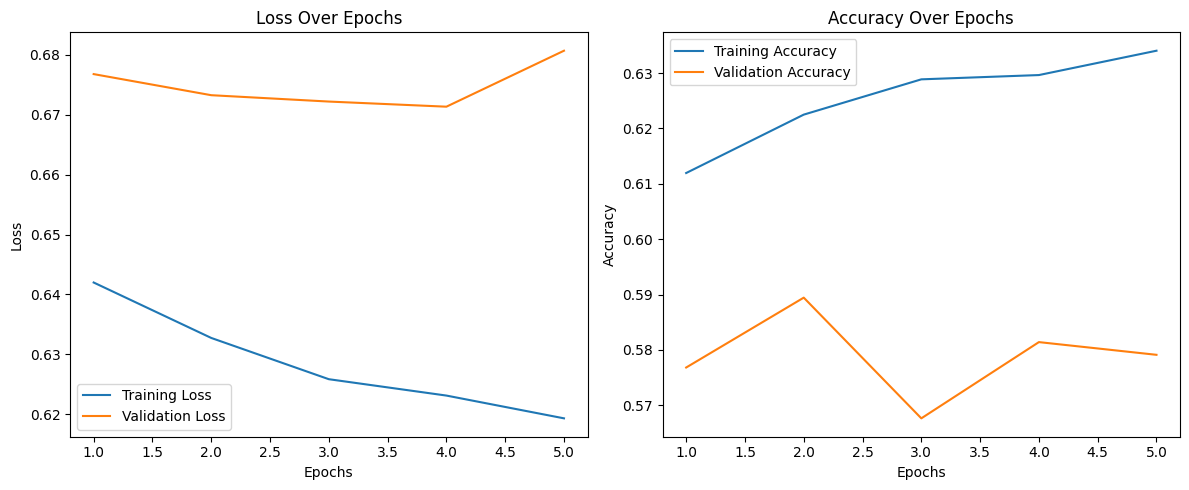

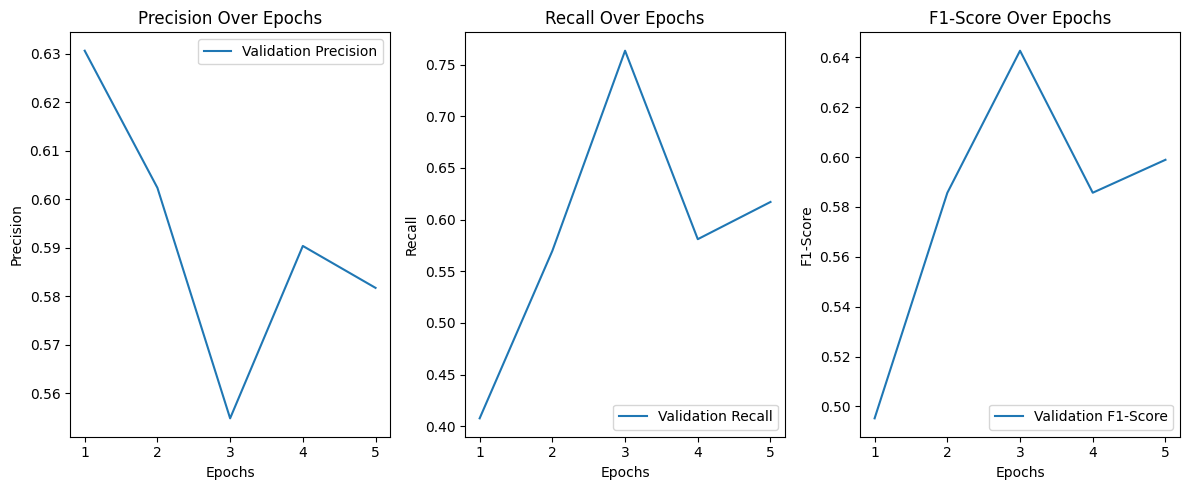

Confusion Matrix Evaluation: 100%|██████████████████████████████████| 28/28 [00:00<00:00, 28.56it/s]


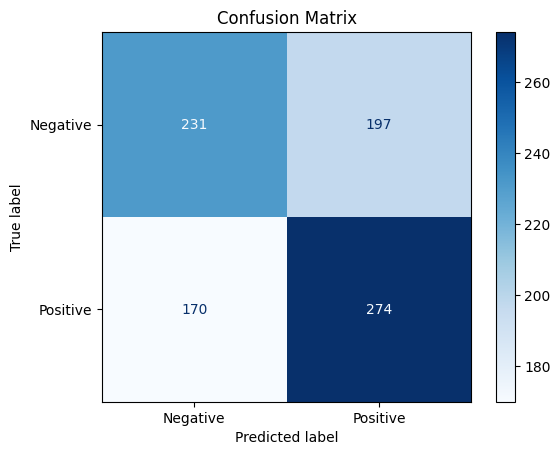

In [19]:
plot_history(history)
plot_confusion_matrix(gpt2classifier, validation_loader, device)

In [29]:
import torch.optim as optim

class GPT2ClassifierWithLinearLayer(nn.Module):
    def __init__(self, pretrained_model, num_labels=2):
        super(GPT2ClassifierWithLinearLayer, self).__init__()
        self.encoder = pretrained_model.transformer
        self.classifier = nn.Linear(pretrained_model.config.n_embd, num_labels)
        self.LinearLayer = nn.Linear(pretrained_model.config.n_embd, pretrained_model.config.n_embd)
        
    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_length, hidden_size)
        
        # Extract the embedding of the first token (CLS token)
        cls_embedding = hidden_states[:, 0, :]  # Shape: (batch_size, hidden_size)
        
        # Pass the CLS embedding through the classification head
        logits = self.LinearLayer(cls_embedding)
        logits = self.classifier(logits)  # Shape: (batch_size, num_labels)
        return logits

# define model, critertion and stuff
gpt2classifierWithLL = GPT2ClassifierWithLinearLayer(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gpt2classifier.parameters(), lr=1e-5)


In [30]:
num_epoch = 5
history = train_model(gpt2classifierWithLL, train_loader, validation_loader, optimizer, criterion, num_epoch, device)


Epoch 1/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.01it/s, Loss=0.6995, Acc=0.6328]


Training Loss: 0.6213 | Training Accuracy: 0.6328


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.77it/s, Loss=0.6707, Acc=0.5000]


Validation Loss: 0.6757 | Validation Accuracy: 0.5711
Validation Precision: 0.5678 | Validation Recall: 0.6599 | Validation F1-Score: 0.6104

Epoch 2/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.01it/s, Loss=0.7196, Acc=0.6373]


Training Loss: 0.6161 | Training Accuracy: 0.6373


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.72it/s, Loss=0.6842, Acc=0.5000]


Validation Loss: 0.6842 | Validation Accuracy: 0.5791
Validation Precision: 0.5842 | Validation Recall: 0.6014 | Validation F1-Score: 0.5927

Epoch 3/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.01it/s, Loss=0.6769, Acc=0.6401]


Training Loss: 0.6134 | Training Accuracy: 0.6401


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.79it/s, Loss=0.6741, Acc=0.5000]


Validation Loss: 0.6824 | Validation Accuracy: 0.5608
Validation Precision: 0.5483 | Validation Recall: 0.7793 | Validation F1-Score: 0.6437

Epoch 4/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.01it/s, Loss=0.7710, Acc=0.6404]


Training Loss: 0.6120 | Training Accuracy: 0.6404


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.83it/s, Loss=0.6718, Acc=0.6250]


Validation Loss: 0.6944 | Validation Accuracy: 0.5688
Validation Precision: 0.5521 | Validation Recall: 0.8108 | Validation F1-Score: 0.6569

Epoch 5/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:22<00:00,  8.01it/s, Loss=0.4991, Acc=0.6408]


Training Loss: 0.6102 | Training Accuracy: 0.6408


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.81it/s, Loss=0.7004, Acc=0.5000]


Validation Loss: 0.6883 | Validation Accuracy: 0.5803
Validation Precision: 0.5859 | Validation Recall: 0.5991 | Validation F1-Score: 0.5924


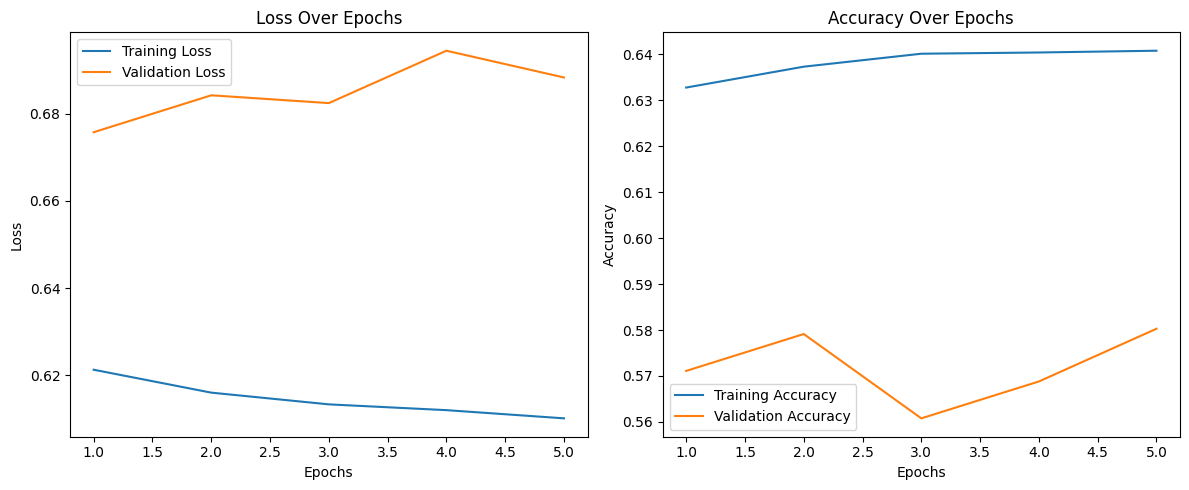

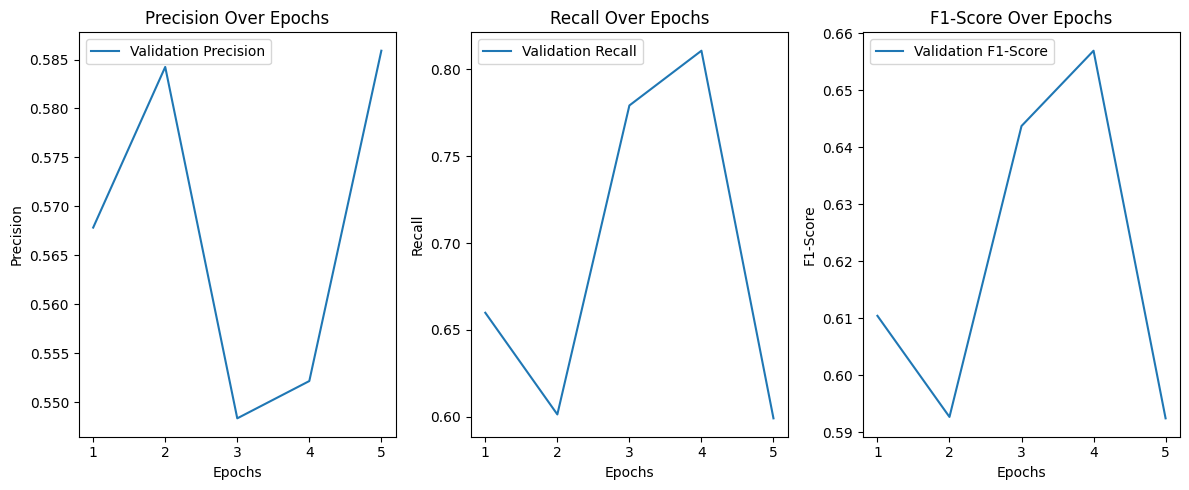

Confusion Matrix Evaluation: 100%|██████████████████████████████████| 28/28 [00:00<00:00, 28.28it/s]


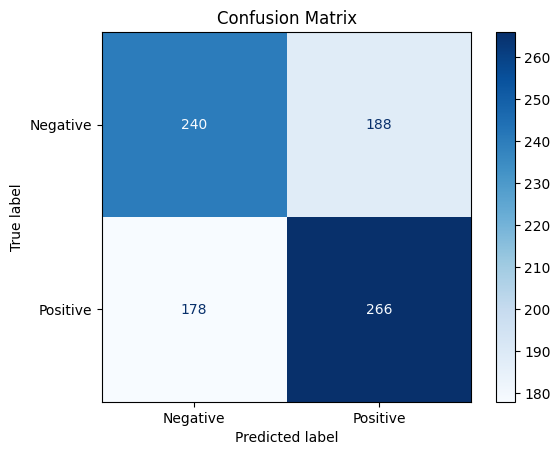

In [31]:
plot_history(history)
plot_confusion_matrix(gpt2classifierWithLL, validation_loader, device)

In [34]:
class GPT2ClassifierWithAttentionLayer(nn.Module):
    def __init__(self, pretrained_model, num_labels=2, num_heads=12):
        super(GPT2ClassifierWithAttentionLayer, self).__init__()
        self.encoder = pretrained_model.transformer
        self.attention = nn.MultiheadAttention(pretrained_model.config.n_embd, num_heads=num_heads, batch_first=True)
        self.classifier = nn.Linear(pretrained_model.config.n_embd, num_labels)
        
    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_length, hidden_size)
        
        # Extract CLS token embedding
        cls_embedding = hidden_states[:, 0, :]  # (batch_size, hidden_size)
        cls_embedding = cls_embedding.unsqueeze(1)  # (batch_size, 1, hidden_size)
        
        # Apply bidirectional attention
        attn_output, _ = self.attention(cls_embedding, hidden_states, hidden_states, key_padding_mask=~attention_mask.bool() if attention_mask is not None else None)
        
        # Pass through classifier
        logits = self.classifier(attn_output.squeeze(1))  # (batch_size, num_labels)
        
        return logits

# define model, criterion and stuff
gpt2classifierWithAttention = GPT2ClassifierWithAttentionLayer(model).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gpt2classifierWithAttention.parameters(), lr=1e-5)


In [35]:
num_epoch = 5
history = train_model(gpt2classifierWithAttention, train_loader, validation_loader, optimizer, criterion, num_epoch, device)


Epoch 1/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:26<00:00,  7.89it/s, Loss=0.2888, Acc=0.8514]


Training Loss: 0.3364 | Training Accuracy: 0.8514


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.40it/s, Loss=0.5235, Acc=0.7500]


Validation Loss: 0.3091 | Validation Accuracy: 0.8819
Validation Precision: 0.8605 | Validation Recall: 0.9167 | Validation F1-Score: 0.8877

Epoch 2/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:27<00:00,  7.88it/s, Loss=0.4416, Acc=0.9132]


Training Loss: 0.2172 | Training Accuracy: 0.9132


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.30it/s, Loss=0.5658, Acc=0.8750]


Validation Loss: 0.3015 | Validation Accuracy: 0.8968
Validation Precision: 0.8831 | Validation Recall: 0.9189 | Validation F1-Score: 0.9007

Epoch 3/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:26<00:00,  7.89it/s, Loss=0.1091, Acc=0.9343]


Training Loss: 0.1719 | Training Accuracy: 0.9343


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.29it/s, Loss=0.3252, Acc=0.8750]


Validation Loss: 0.2853 | Validation Accuracy: 0.9002
Validation Precision: 0.8906 | Validation Recall: 0.9167 | Validation F1-Score: 0.9034

Epoch 4/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:27<00:00,  7.86it/s, Loss=0.0402, Acc=0.9464]


Training Loss: 0.1412 | Training Accuracy: 0.9464


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.26it/s, Loss=0.6922, Acc=0.7500]


Validation Loss: 0.3257 | Validation Accuracy: 0.8899
Validation Precision: 0.8734 | Validation Recall: 0.9167 | Validation F1-Score: 0.8945

Epoch 5/5
--------------------------------------------------


Training: 100%|████████████████████████| 2105/2105 [04:27<00:00,  7.86it/s, Loss=0.0078, Acc=0.9567]


Training Loss: 0.1184 | Training Accuracy: 0.9567


Validation: 100%|██████████████████████████| 28/28 [00:01<00:00, 27.26it/s, Loss=0.5575, Acc=0.7500]

Validation Loss: 0.3355 | Validation Accuracy: 0.8968
Validation Precision: 0.8933 | Validation Recall: 0.9054 | Validation F1-Score: 0.8993


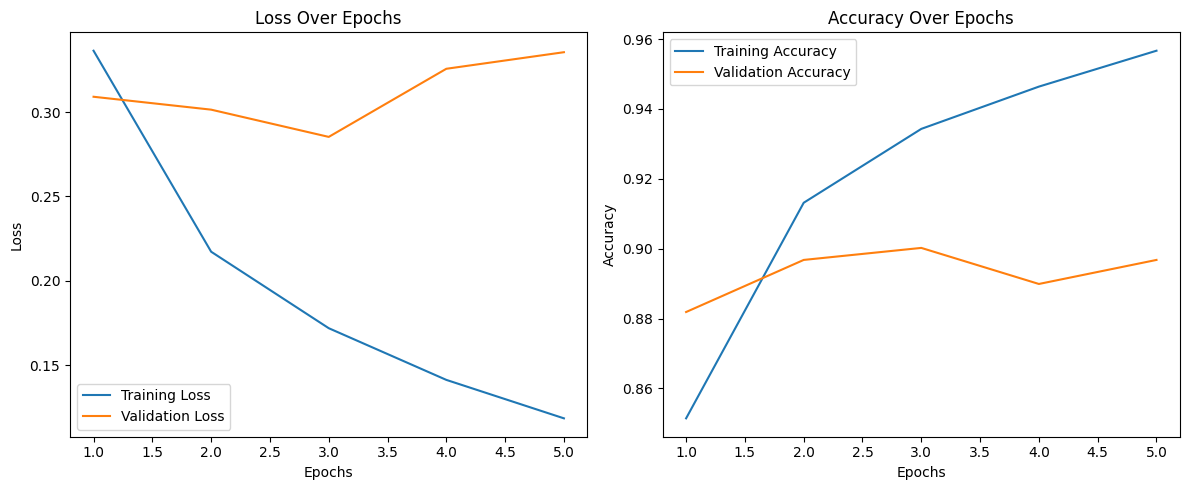

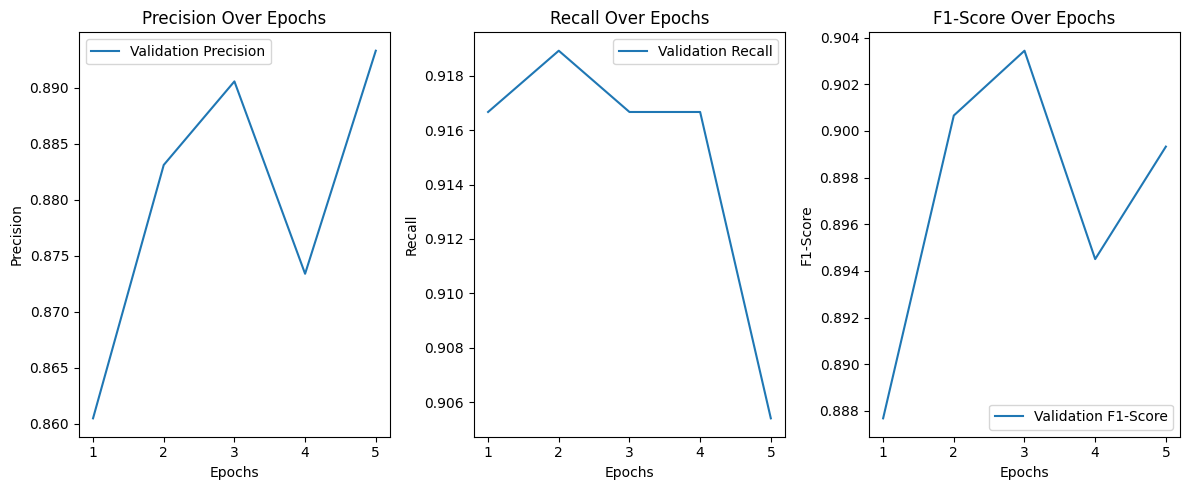

Confusion Matrix Evaluation: 100%|██████████████████████████████████| 28/28 [00:01<00:00, 27.85it/s]


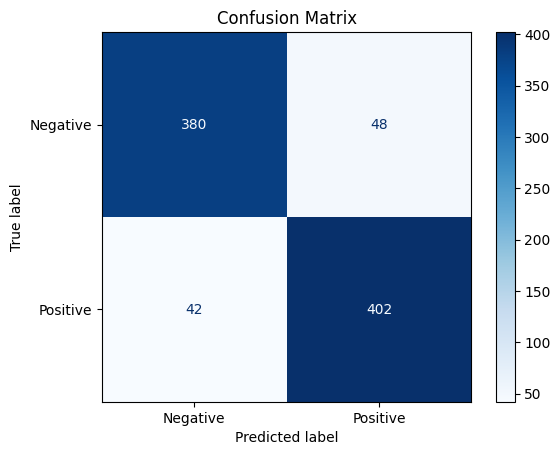

In [36]:
plot_history(history)
plot_confusion_matrix(gpt2classifierWithAttention, validation_loader, device)

Zero-shot performance (Accuracy): 0.9128


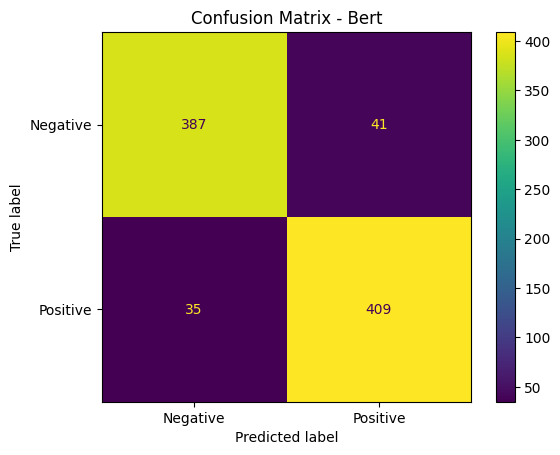

In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
!pip install evaluate
import evaluate


model_name = "textattack/bert-base-uncased-SST-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


tokenized_dataset = dataset.map(tokenize_and_pad, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["sentence", "idx"])
tokenized_dataset = tokenized_dataset.with_format("torch")

val_dataset = tokenized_dataset["validation"]

model.eval()
def predict(model, dataloader):
    predictions = []
    true_labels = []
    for batch in dataloader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.tolist())
        true_labels.extend(batch["label"].tolist())
    
    return predictions, true_labels
    
val_dataloader = DataLoader(val_dataset, batch_size=16)
preds, true_labels = predict(model, val_dataloader)
accuracy_metric = evaluate.load("accuracy")
accuracy = accuracy_metric.compute(predictions=preds, references=true_labels)
print(f"Zero-shot performance (Accuracy): {accuracy['accuracy']:.4f}")
cm = confusion_matrix(true_labels, preds)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot()
plt.title("Confusion Matrix - Bert")
plt.show()

---------
### References

[1] Raffel, Colin, Noam Shazeer, Adam Roberts, et al. (2020). *Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer*. [Link to paper](https://arxiv.org/abs/1910.10683)

[2] Touvron, Hugo, et al. (2023). *LLaMA 2: Open Foundation and Fine-Tuned Chat Models*. [Link to paper](https://arxiv.org/abs/2307.09288)

<span style="color:yellow;">*For further reading on this field of research, you can refer to the following papers:*</span>

[3] BehnamGhader, Adlakha, et al. (2024). *LLM2Vec: Large Language Models Are Secretly Powerful Text Encoders*. [Link to paper](https://arxiv.org/abs/2404.05961)

[4] Gao, Tianyu, et al. (2021). *SimCSE: Simple Contrastive Learning of Sentence Embeddings*. [Link to paper](https://arxiv.org/abs/2104.08821)

[5] Lee, et al. (2023). *NV-Embed: Improved Techniques for Training LLMs as Generalist Embedding Models*. [Link to paper](https://arxiv.org/abs/2405.17428)




# **Best regards.**